_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote, Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat GPT, used for autompletion and debugging.*

# Project 3: Single-cell data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##
import os
import scrublet as scr  # for single-cell RNA-seq doublet detection

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
current_path = os.getcwd()
if not current_path.endswith("notebooks"):
    os.chdir(os.path.join(current_path, "notebooks"))

variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data/project-03")

In [4]:
plt.style.use("../matplotlib_style.txt")

In [5]:
np.random.seed(42)

## Project and data description

In this project, we are going to work with the typical methods and pipelines used in single-cell data analysis and get some hands-on experience with the techniques used in the field. For that, we will be using Patch-seq multimodal data from cortical neurons in mice, from Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). From the different data modalities they used, we will focus on transcriptomics and electrophysiological data. 

In a real-world scenario, single cell data rarely comes with any "ground truth" labels. Often, the goal of researchers after measuring cells is to precisely classify them, grouping them into families or assigning them cell types based on the recorded features. This is normally done using usupervised methods, such as clustering methods.

However, the single-cell data that we are using in this project has some cell types assigned to each cell. These are not "ground truth" type annotations, but were one of the results from the original Scala et al. work. Still, we are going to use those annotations for validation (despite them not really being ground truth) to sanity-check some of our analyses, such as visualizations, clustering, etc. We will mainly work with cell types (`rna_types`, 77 unique types) and cell families (`rna_families`, 9 unique families).

From the transcriptomics mRNA counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out.

## Import data

### Meta data

In [6]:
# META DATA
meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


In [7]:
meta.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

### "Ground truth labels"

In [8]:
# filter out low quality cells in term of RNA
print(
    "There are",
    np.sum(meta["RNA family"] == "low quality"),
    "cells with low quality RNA recordings.",
)
exclude_low_quality = meta["RNA family"] != "low quality"

There are 97 cells with low quality RNA recordings.


In [9]:
rna_family = meta["RNA family"][exclude_low_quality]
rna_type = meta["RNA type"][exclude_low_quality]
rna_family

0          ET
1          IT
2          IT
3          ET
4          ET
        ...  
1323       IT
1324       IT
1325     Sncg
1326       ET
1328    Pvalb
Name: RNA family, Length: 1232, dtype: object

In [10]:
print(len(np.unique(rna_family)))
print(len(np.unique(rna_type)))

9
77


In [11]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [12]:
rna_type_colors = np.vectorize(dict_rna_type_colors.get)(rna_type)

### Transcriptomic data

In [13]:
# READ COUNTS
data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

# filter out low quality cells in term of rna family
exonCounts = data_exons.values.transpose()[exclude_low_quality]
print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1232, 42466)


In [14]:
# GENE LENGTH
data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values

### Electrophysiological features

In [15]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [16]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData[exclude_low_quality]
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1232, 29)
(1224, 17)


In [17]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).
    

---
---
# Code & Solution


## 1. Metrics for Transcriptomics Data based on Luecken & Theis (2019)

---

### 1. Cell-level Quality Control

- **Total counts per cell (count depth)**  
  Sum of all detected transcripts in each barcode; low values flag empty droplets, high values flag potential doublets.

- **Number of genes detected per cell**  
  Count of unique genes with ≥1 read; informs library complexity and cell viability.

- **Mitochondrial content (% mito reads)**  
  Fraction of reads mapping to mitochondrial genes; high percentages indicate stressed or dying cells.

- **Doublet score**  
  Algorithmic probability that a barcode captures more than one cell (e.g., Scrublet, DoubletFinder).

*Guideline:* Visualize these three QC covariates jointly and set permissive thresholds; revisit after initial downstream analysis for unforeseen cell populations.

---

### 2. Gene-level Filtering

- **Detection frequency**  
  Number (or percent) of cells in which a gene is expressed; genes with very low frequency are uninformative.

- **Average (normalized) expression**  
  Mean expression across cells; extremely low or high values may bias downstream analyses.

- **Dispersion (variance/mean)**  
  Overdispersion metric used to select highly variable genes (HVGs) for feature selection.

*Rule of thumb:*  
Filter out genes detected in fewer cells than the smallest cluster size you aim to resolve (e.g., <20 cells).

---

### 3. Normalization Diagnostics

- **Size factors**  
  Cell-specific scaling factors (e.g., via scran pooling) that correct for sequencing depth disparities.

- **Mean-variance trend**  
  Post-normalization relationship; a flat trend indicates removal of depth-related variance.

- **Log-transformation stability**  
  After log(x+1), check that data skewness is mitigated and fold-change interpretations hold.

*Tip:*  
Compare alternative normalization methods (CPM, scran, downsampling) using dedicated tools (e.g., scone) to pick the best fit for your data.

---

### 4. Batch Effect Assessment

| Metric                      | Purpose                                                         |
|-----------------------------|-----------------------------------------------------------------|
| Variance partitioning       | % variance attributed to batch vs. biological factors           |
| kBET acceptance rate        | Statistical test for local mixing of batches                    |
| Local Inverse Simpson’s Index (LISI) | Quantifies neighborhood batch diversity                |
| PCA-based silhouette score  | Separation of cells by batch in low-dimensional embedding       |

*Best practice:*  
Design experiments to minimize batch effects (multiplexing, cell hashing) and then apply ComBat or linear regression for within-experiment correction.

---

### 5. Integration & Clustering Metrics

- **Silhouette width**  
  Measures how similar each cell is to its own cluster vs. other clusters.

- **Adjusted Rand Index (ARI)**  
  Compares clustering results to known labels or gold standards.

- **Normalized Mutual Information (NMI)**  
  Evaluates similarity between two partitions; useful when labels are probabilistic.

- **Clustering stability**  
  Re-run clustering on data subsets or bootstraps to assess robustness of cluster assignments.

---

### 6. Trajectory & Pseudotime Quality

- **Moran’s I for trajectory genes**  
  Spatial autocorrelation of gene expression along inferred trajectory.

- **Kendall’s τ correlation**  
  Agreement between pseudotime ordering and known marker progression.

- **Branch assignment consistency**  
  Cross-validation of lineage splits using subsampling.

---

References  
1. Luecken MD, Theis FJ. Current best practices in single-cell RNA-seq analysis: a tutorial. Mol Syst Biol. 2019;15:e8746.

## 1. Cell-level Quality Control Metrics (on the non-normalized data)

In [18]:
# total counts per cell
total_counts_per_cell = np.sum(exonCounts, axis=1)
print(
    "Range of total counts per cell:",
    np.min(total_counts_per_cell),
    "to",
    np.max(total_counts_per_cell),
)

# number of expressed genes per cell
n_expressed_genes_per_cell = np.sum(exonCounts > 0, axis=1)
print(
    "Range of number of expressed genes per cell:",
    np.min(n_expressed_genes_per_cell),
    "to",
    np.max(n_expressed_genes_per_cell),
)

# mitochondrial content
mito_genes_mask = np.char.startswith(genes.astype(str), "mt-")
print(f"Found {np.sum(mito_genes_mask)} mitochondrial genes.")
mito_counts = exonCounts[:, mito_genes_mask]
percent_mito = (np.sum(mito_counts, axis=1) / np.sum(exonCounts, axis=1)) * 100
print(
    "Range of mitochondrial content:",
    f"{np.min(percent_mito):.2f}% to {np.max(percent_mito):.2f}%",
)

# mean count per gene
mean_counts_per_gene = np.mean(exonCounts, axis=0)

# variance per gene
var_counts_per_gene = np.var(exonCounts, axis=0)

# detection frequency per gene
detection_frequency_per_gene = np.sum(exonCounts > 0, axis=0)

Range of total counts per cell: 2648 to 18479190
Range of number of expressed genes per cell: 1202 to 18118
Found 28 mitochondrial genes.
Range of mitochondrial content: 0.02% to 48.97%


In [19]:
# Calculate optimal bin numbers using the Freedman-Diaconis rule
def get_fd_bins(data):
    """
    Calculates the optimal number of bins for a histogram using the Freedman-Diaconis rule.
    If the rule suggests too few bins (<=1), it falls back to using the number of unique
    data points, capped at 50, for better visualization of sparse data.
    If there is only one unique data point (e.g., all zeros), it returns a bin range
    centered around that value.
    """
    unique_values = np.unique(data)
    if len(unique_values) == 1:
        # Handle case with only one unique value, e.g., all zeros.
        # Create a small bin around the single value.
        value = unique_values[0]
        return [value - 0.5, value + 0.5]

    # Freedman-Diaconis rule
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    if iqr > 0:
        bin_width = 2 * iqr * (len(data) ** (-1 / 3))
        if bin_width > 0:
            num_bins = int((np.max(data) - np.min(data)) / bin_width)
            # If FD rule gives a reasonable number of bins, use it.
            if num_bins > 1:
                return num_bins

    # Fallback for sparse data or when FD rule is not informative
    # Use the number of unique values, but cap it at 50 to avoid too many bins.
    num_bins = len(unique_values)
    return min(num_bins, 50)

In [20]:
# Calculate Freedman-Diaconis bins for the different metrics
bins_total_counts = get_fd_bins(total_counts_per_cell)
bins_expressed_genes = get_fd_bins(n_expressed_genes_per_cell)
bins_percent_mito = get_fd_bins(percent_mito)
bins_detection_frequency = get_fd_bins(detection_frequency_per_gene)

C:\Users\Julius\AppData\Local\Temp\ipykernel_24060\3584003151.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


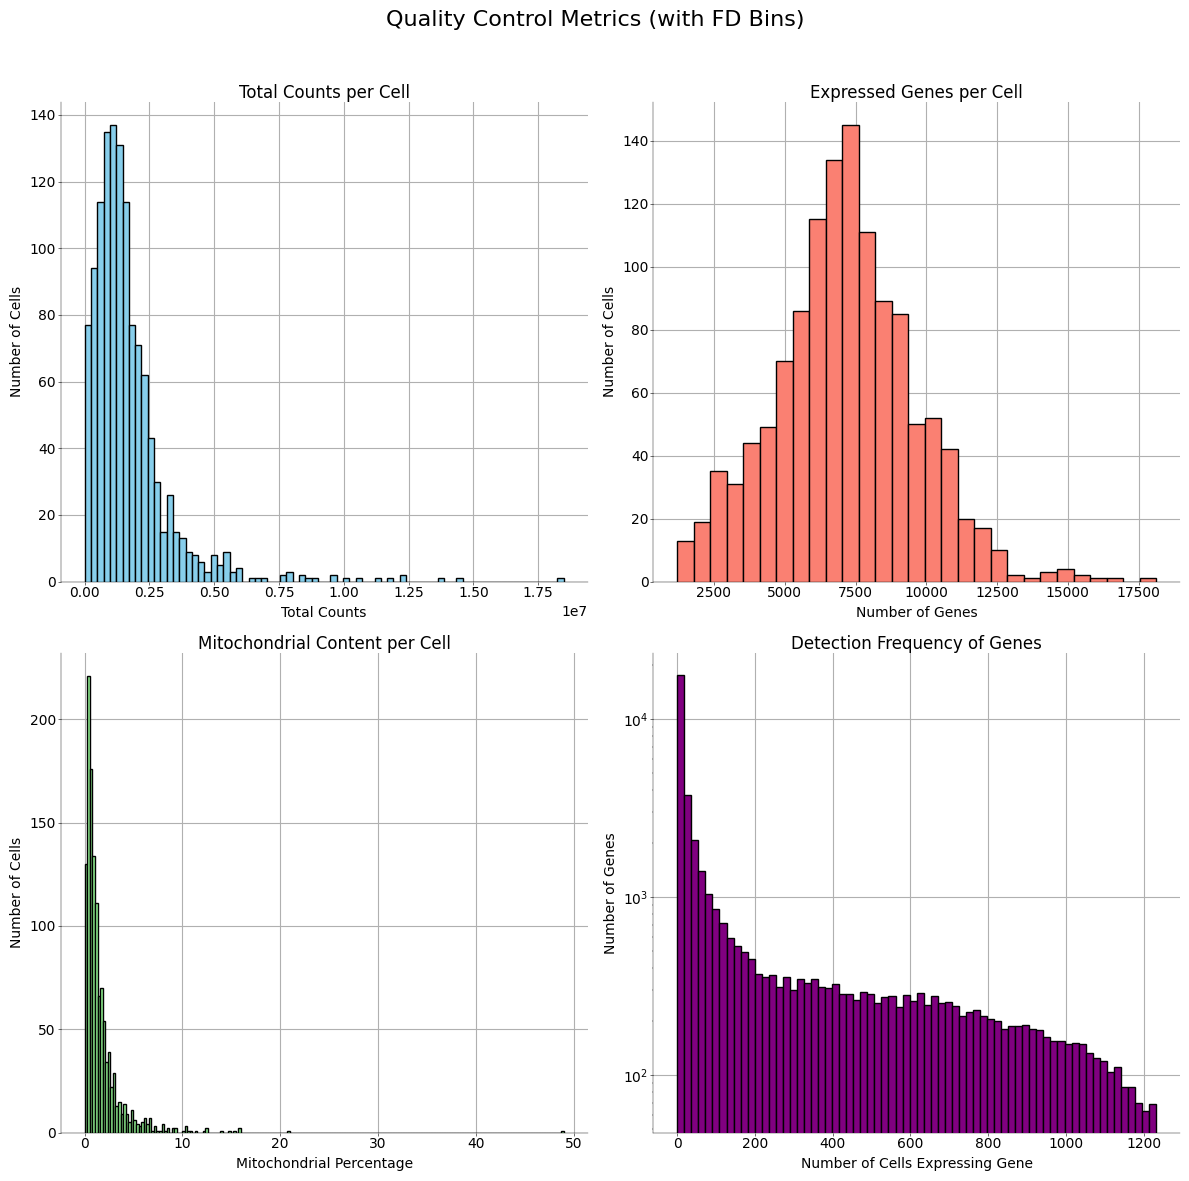

In [21]:
import matplotlib.gridspec as gridspec

# plot the the counts together on one plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Quality Control Metrics (with FD Bins)", fontsize=16)

# Plot 1: Total counts per cell
axes[0, 0].hist(
    total_counts_per_cell,
    bins=bins_total_counts,
    color="skyblue",
    edgecolor="black",
    zorder=10,
)
axes[0, 0].set_title("Total Counts per Cell")
axes[0, 0].set_xlabel("Total Counts")
axes[0, 0].set_ylabel("Number of Cells")
axes[0, 0].grid(True)

# Plot 2: Number of expressed genes per cell
axes[0, 1].hist(
    n_expressed_genes_per_cell,
    bins=bins_expressed_genes,
    color="salmon",
    edgecolor="black",
    zorder=10,
)
axes[0, 1].set_title("Expressed Genes per Cell")
axes[0, 1].set_xlabel("Number of Genes")
axes[0, 1].set_ylabel("Number of Cells")
axes[0, 1].grid(True)

# Plot 3: Mitochondrial content
axes[1, 0].hist(
    percent_mito,
    bins=bins_percent_mito,
    color="lightgreen",
    edgecolor="black",
    zorder=10,
)
axes[1, 0].set_title("Mitochondrial Content per Cell")
axes[1, 0].set_xlabel("Mitochondrial Percentage")
axes[1, 0].set_ylabel("Number of Cells")
axes[1, 0].grid(True)

# Plot 4: Detection Frequency of Genes
axes[1, 1].hist(
    detection_frequency_per_gene,
    bins=bins_detection_frequency,
    color="purple",
    edgecolor="black",
    zorder=10,
)
axes[1, 1].set_title("Detection Frequency of Genes")
axes[1, 1].set_xlabel("Number of Cells Expressing Gene")
axes[1, 1].set_ylabel("Number of Genes")
axes[1, 1].set_yscale("log")
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

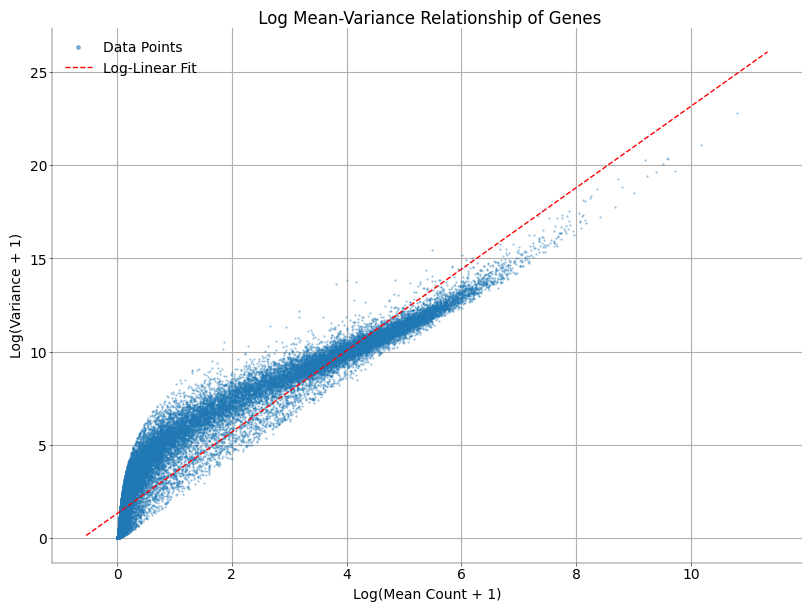

In [22]:
# Plot Mean-variance relationship
fig, ax = plt.subplots(figsize=(8, 6))

# calculate in log + 1 space because of the large range of values and to avoid log(0)
x_data = np.log1p(mean_counts_per_gene)
y_data = np.log1p(var_counts_per_gene)

# Filter out non-finite values for robust fitting
valid_indices = np.isfinite(x_data) & np.isfinite(y_data)
x_data_fin = x_data[valid_indices]
y_data_fin = y_data[valid_indices]

ax.scatter(
    x_data_fin,
    y_data_fin,
    alpha=0.5,
    s=1,
    zorder=10,
    label="Data Points",
)

# Add a linear fit
m, b = np.polyfit(x_data_fin, y_data_fin, 1)
fit_x = np.array(ax.get_xlim())
ax.plot(
    fit_x,
    m * fit_x + b,
    color="red",
    zorder=20,
    linestyle="--",
    label="Log-Linear Fit",
)

ax.set_title(" Log Mean-Variance Relationship of Genes")
ax.set_xlabel("Log(Mean Count + 1)")
ax.set_ylabel("Log(Variance + 1)")
ax.grid(True)
ax.legend(loc="upper left", markerscale=5)
plt.show()

### Single Gene Expression Distribution within Cell Types

Below, we select three representative genes (low, medium, and high expression) and the three most common cell types to create a grid of histograms. Each plot shows how the counts for a single gene are distributed across the cells of a particular type.

Selected genes for plotting: ['Gm47127' '4930512B01Rik' 'Letmd1']
Their mean counts are: [ 0.48782468  7.43506494 96.22483766]
Selected cell types for plotting: ['Pvalb Il1rapl2' 'L2/3 IT_3' 'Pvalb Reln']


C:\Users\Julius\AppData\Local\Temp\ipykernel_24060\40997702.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout(


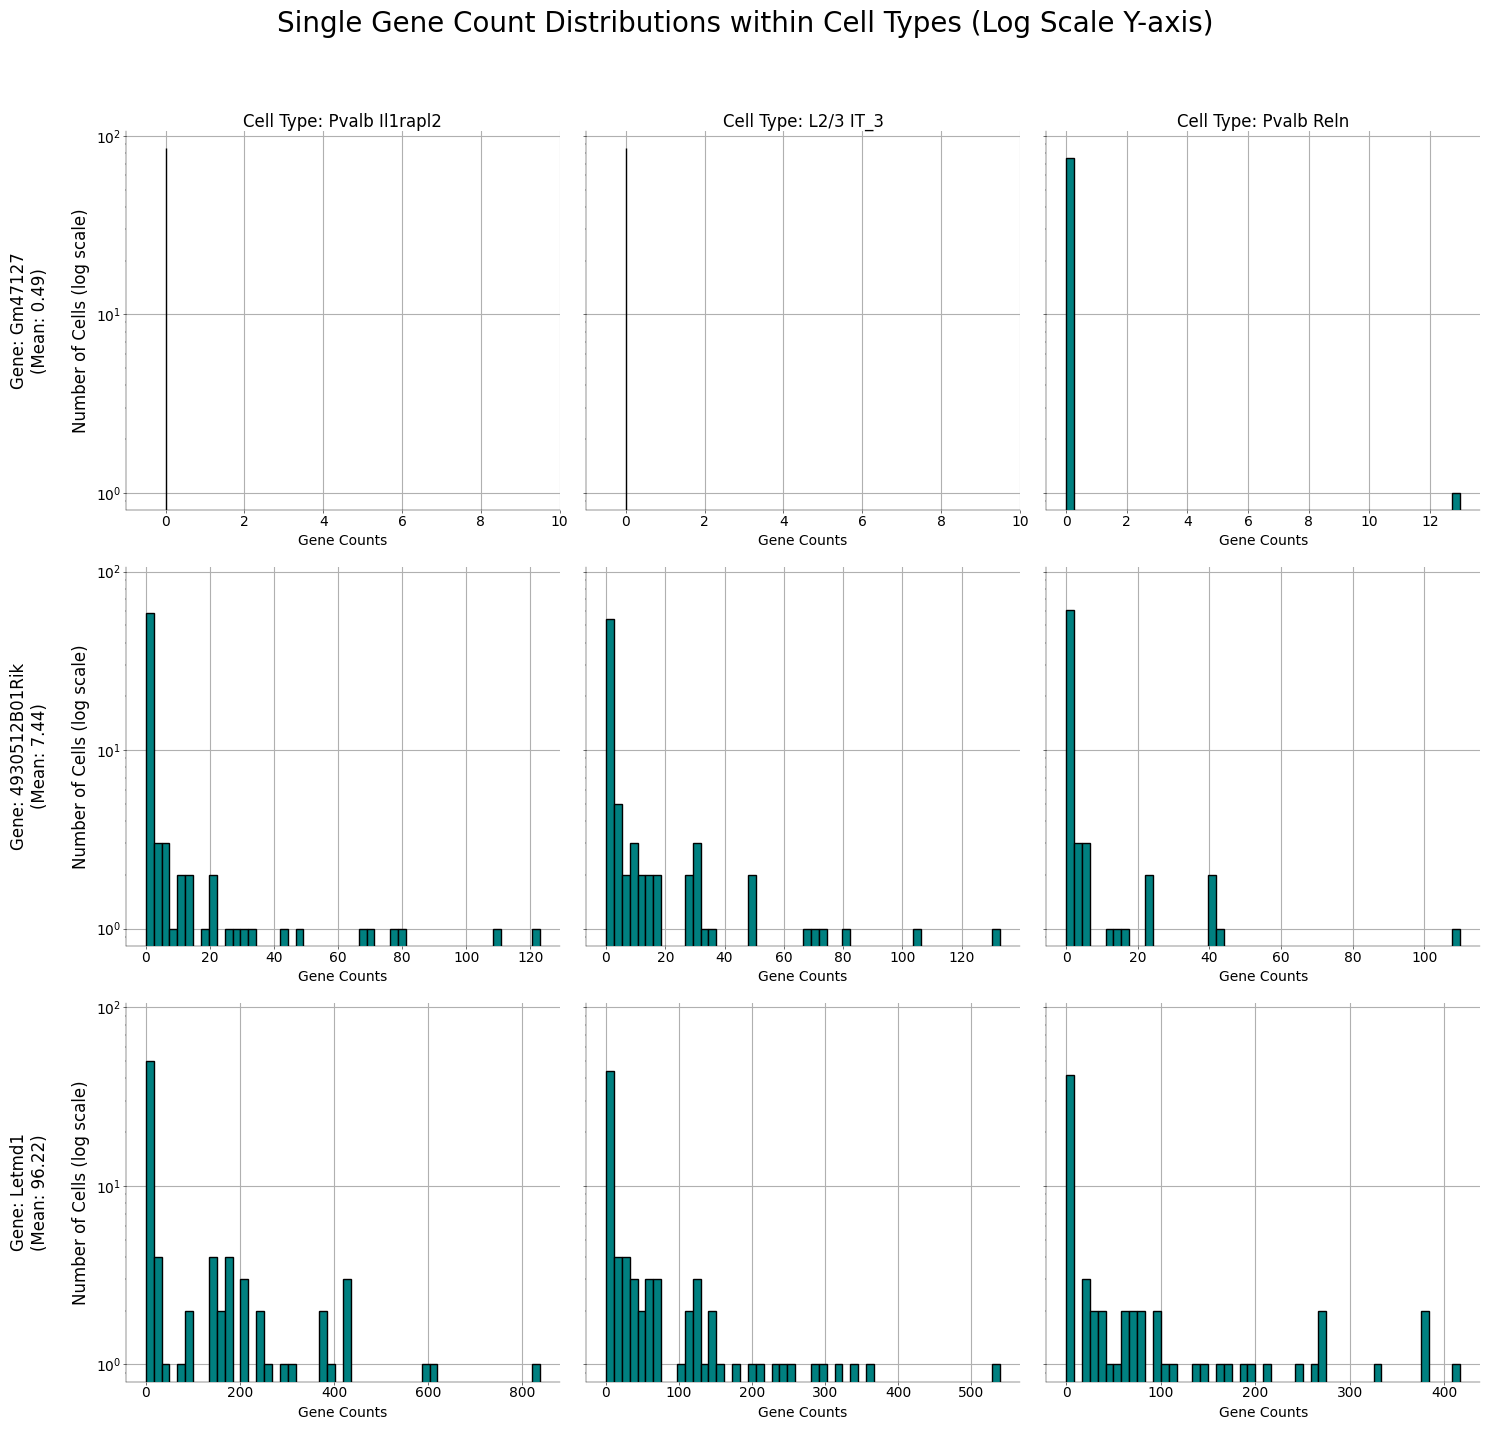

In [23]:
# 1. Select a few example genes based on their mean expression
# We sort genes by their mean count and pick representatives from different parts of the distribution.
sorted_indices = np.argsort(mean_counts_per_gene)

# Picking genes at 50th, 70th, and 90th percentiles for a better spread of expressed genes
low_expr_gene_idx = sorted_indices[int(len(sorted_indices) * 0.50)]
mid_expr_gene_idx = sorted_indices[int(len(sorted_indices) * 0.70)]
high_expr_gene_idx = sorted_indices[int(len(sorted_indices) * 0.90)]

selected_gene_indices = [
    low_expr_gene_idx,
    mid_expr_gene_idx,
    high_expr_gene_idx,
]
selected_gene_names = genes[selected_gene_indices]

print(f"Selected genes for plotting: {selected_gene_names}")
print(f"Their mean counts are: {mean_counts_per_gene[selected_gene_indices]}")

# 2. Select the three most common cell types
unique_types, counts = np.unique(rna_type, return_counts=True)
sorted_type_indices = np.argsort(counts)[::-1]  # Sort descending
selected_cell_types = unique_types[sorted_type_indices[:3]]

print(f"Selected cell types for plotting: {selected_cell_types}")


# 3. Create a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig.suptitle(
    "Single Gene Count Distributions within Cell Types (Log Scale Y-axis)",
    fontsize=20,
)

for i, gene_idx in enumerate(selected_gene_indices):
    for j, cell_type in enumerate(selected_cell_types):
        # Get the mask for the current cell type
        cell_mask = rna_type == cell_type

        # Get the counts for the current gene in the selected cells
        gene_counts_in_cell_type = exonCounts[cell_mask, gene_idx]

        ax = axes[i, j]
        ax.hist(
            gene_counts_in_cell_type,
            bins=50,  # Use a fixed number of bins for consistency
            color="teal",
            edgecolor="black",
            zorder=10,
        )
        ax.grid(True)
        ax.set_yscale("log")  # Use a log scale for the y-axis

        # If all data is zero, the plot will be a single bar.
        # Adjust x-axis to make it look like a spike, not a block.
        if len(np.unique(gene_counts_in_cell_type)) == 1:
            ax.set_xlim(-1, max(10, np.max(gene_counts_in_cell_type) + 1))

        # Set titles
        if i == 0:
            ax.set_title(f"Cell Type: {cell_type}", fontsize=12)
        if j == 0:
            ax.set_ylabel(
                f"Gene: {selected_gene_names[i]}\n(Mean: {mean_counts_per_gene[gene_idx]:.2f})\n\nNumber of Cells (log scale)",
                fontsize=12,
            )

        ax.set_xlabel("Gene Counts")

plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
)  # Adjust layout to prevent title overlap
plt.show()

### Doublet detection
In scRNA-seq, a small fraction of droplets/wells may capture two or more cells. These are called doublets (or multiplets). Doublets can appear as a third population of cells in-between two other populations and can therefore interfere with downstream analysis, such as clustering. It is therefore important to identify and remove them.

Running Scrublet for doublet detection...
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 1.4%
Elapsed time: 3.8 seconds
Doublet detection complete.
Number of predicted doublets: 1
   Number               Cell             Slice        Date    Sample  \
0       1  20171204_sample_2  20171204_slice_2  2017-12-04  sample 2   
1       2  20171204_sample_4  20171204_slice_4  2017-12-04  sample 4   
2       3  20171204_sample_5  20171204_slice_5  2017-12-04  sample 5   
3       4  20171204_sample_6  20171204_slice_6  2017-12-04  sample 6   
4       5  20171207_sample_1  20171207_slice_1  2017-12-07  sample 1   

         Mouse Mouse date of birth  Mouse age Mouse gender  \
0  mouse_GTOKH          2017-10-29         36            M   
1  mouse_GTOKH       

C:\Users\Julius\AppData\Roaming\Python\Python313\site-packages\scrublet\scrublet.py:507: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


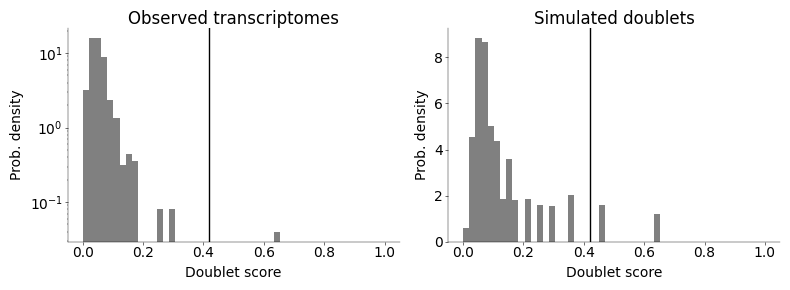

In [24]:
# Create a copy of the filtered metadata before running doublet detection
meta_filtered = meta[exclude_low_quality].copy()

# Now, let's try running Scrublet again with the sparse matrix
print("Running Scrublet for doublet detection...")
scrub = scr.Scrublet(exonCounts, expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(
    min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30
)
print("Doublet detection complete.")

# Add doublet info to meta data
meta_filtered["doublet_scores"] = doublet_scores
meta_filtered["predicted_doublets"] = predicted_doublets

# show new columns and number of doublets
print(f"Number of predicted doublets: {np.sum(predicted_doublets)}")
print(meta_filtered.head())

# Plot a histogram of the doublet scores
scrub.plot_histogram();

## Electrophysiological Features

Shape of final ephys data: (1224, 17)
Number of features: 17


C:\Users\Julius\AppData\Local\Temp\ipykernel_24060\2409193505.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.98])


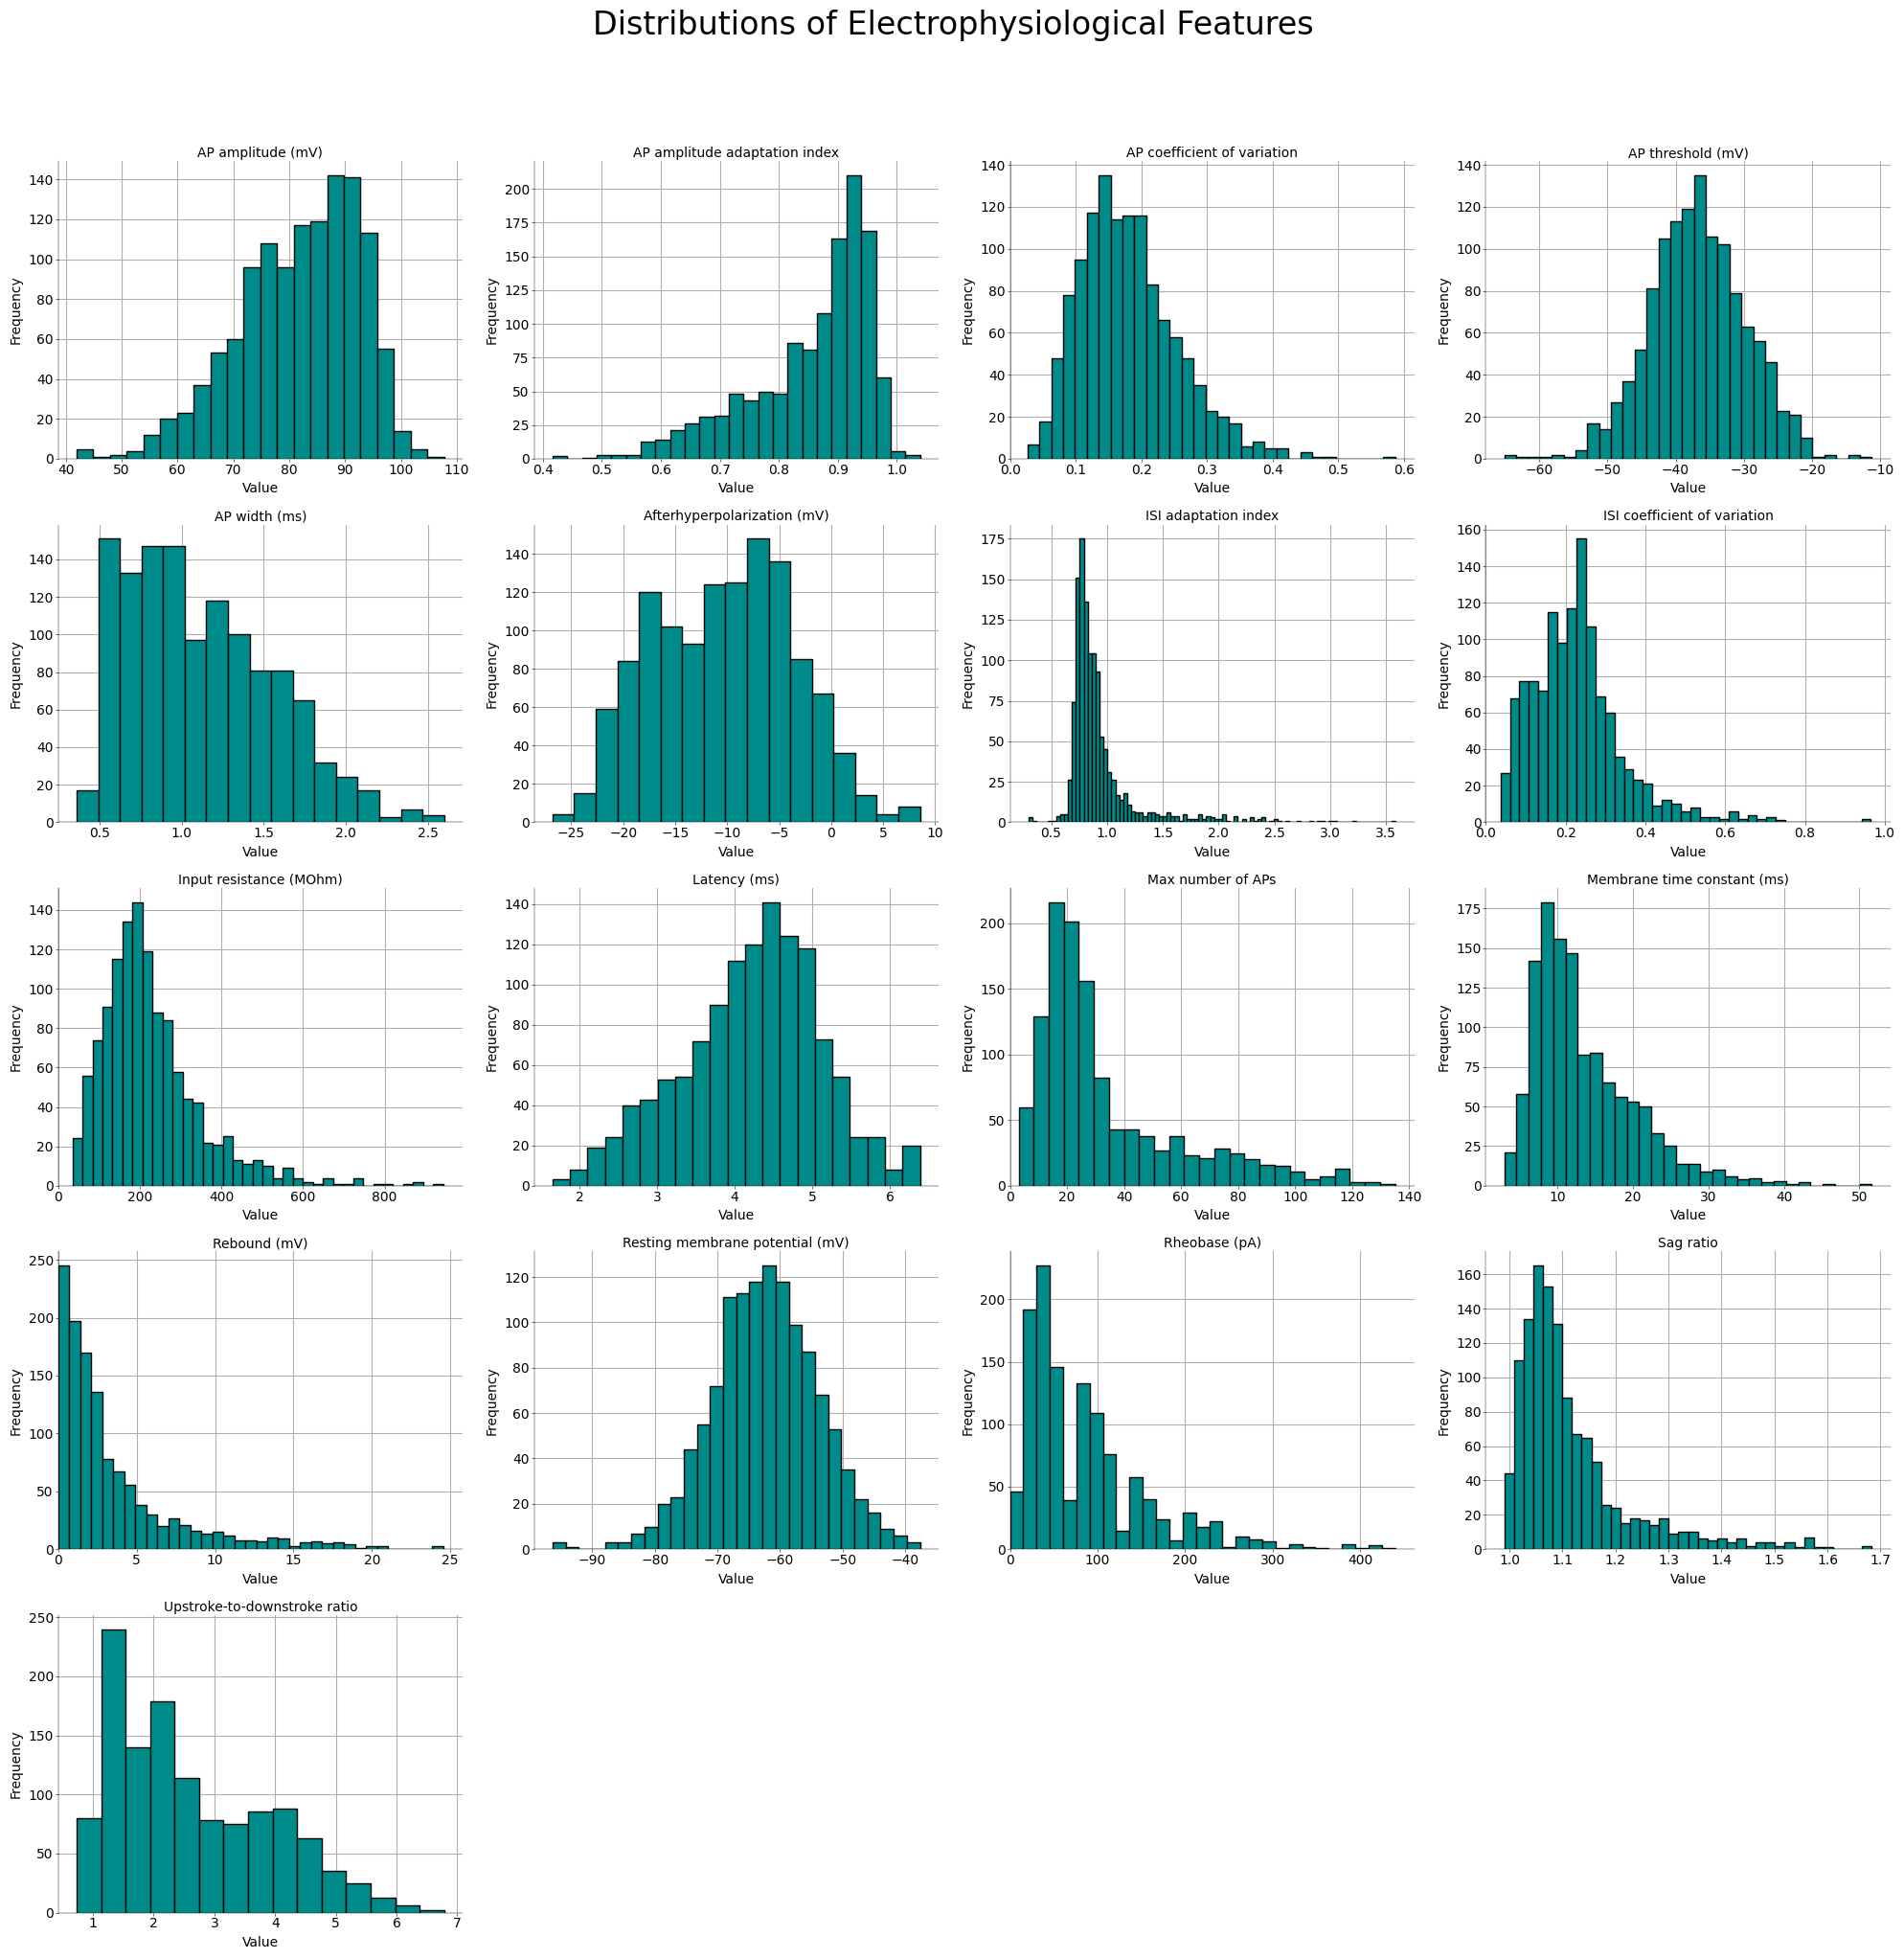

In [25]:
# Start with the data for cells that have high-quality RNA
X_ephys = ephysData[exclude_low_quality].copy()

# Apply log transformation to specified features
# The names for features to be log-transformed are defined in cell 55e28734
for feature_name in features_log:
    feature_idx = np.where(ephysNames == feature_name)[0]
    if len(feature_idx) > 0:
        # Use np.log1p for numerical stability if values are close to 0
        X_ephys[:, feature_idx] = np.log1p(X_ephys[:, feature_idx])

# Filter out excluded features
# The names for features to be excluded are defined in cell 55e28734
feature_mask = ~np.isin(ephysNames, features_exclude)
X_ephys_filtered = X_ephys[:, feature_mask]
ephysNames_filtered = ephysNames[feature_mask]

# Filter out cells with any NaN values after transformations
keepcells_ephys = ~np.isnan(np.sum(X_ephys_filtered, axis=1))
X_ephys_final = X_ephys_filtered[keepcells_ephys, :]

print(f"Shape of final ephys data: {X_ephys_final.shape}")
print(f"Number of features: {len(ephysNames_filtered)}")

# Now, plot the distribution of each feature
num_features = X_ephys_final.shape[1]
# Arrange plots in a grid. Let's aim for a grid that's roughly square.
n_cols = 4
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
fig.suptitle(
    "Distributions of Electrophysiological Features", fontsize=24, y=1.02
)

for i, ax in enumerate(axes.flat):
    if i < num_features:
        feature_data = X_ephys_final[:, i]

        # Use Freedman-Diaconis rule for binning
        bins = get_fd_bins(feature_data)

        ax.hist(
            feature_data,
            bins=bins,
            color="darkcyan",
            edgecolor="black",
            zorder=10,
        )
        ax.set_title(ephysNames_filtered[i], fontsize=10)
        ax.grid(True)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Adjust x-lim for better appearance
        min_val = np.min(feature_data)
        max_val = np.max(feature_data)

        # If the minimum is close to zero, anchor the x-axis at zero.
        # This is common for log-transformed data or positive-only features.
        # We define "close" as being within 5% of the data range from zero.
        range_val = max_val - min_val
        if range_val > 0 and abs(min_val) / range_val < 0.05:
            ax.set_xlim(
                left=0, right=max_val * 1.05
            )  # Add 5% padding to the right

    else:
        # Hide unused subplots
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Distribution of "Ground Truth" Labels and Metadata

To understand the composition of our dataset and identify potential sources of biological variance or technical batches, we will now inspect the distribution of the provided cell type labels (`RNA family` and `RNA type`) and other relevant metadata. This includes anatomical information like the cortical layer and genetic information like the Cre-driver line used for targeting cells.

C:\Users\Julius\AppData\Local\Temp\ipykernel_24060\1741417890.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


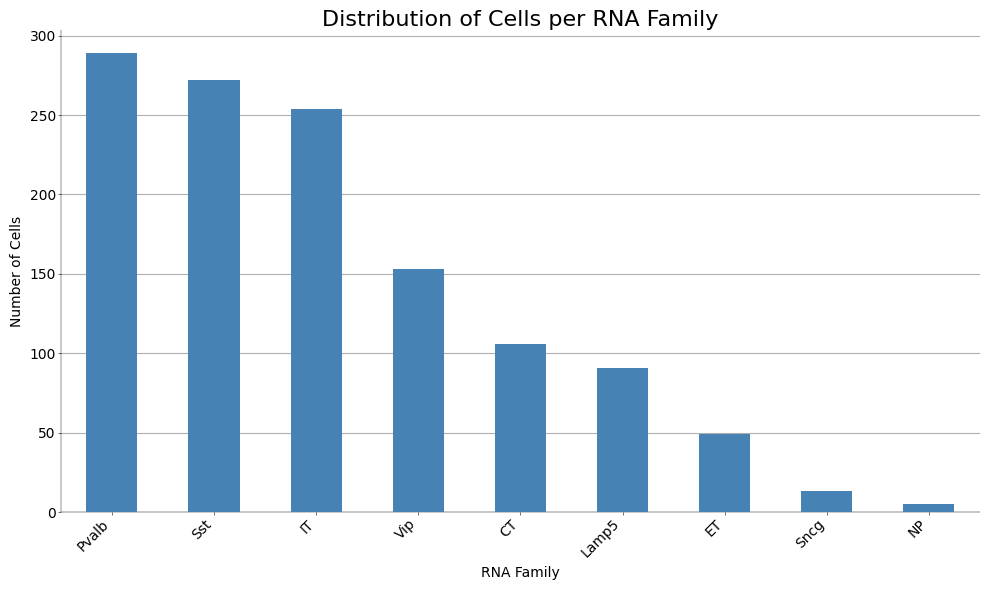

C:\Users\Julius\AppData\Local\Temp\ipykernel_24060\1741417890.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


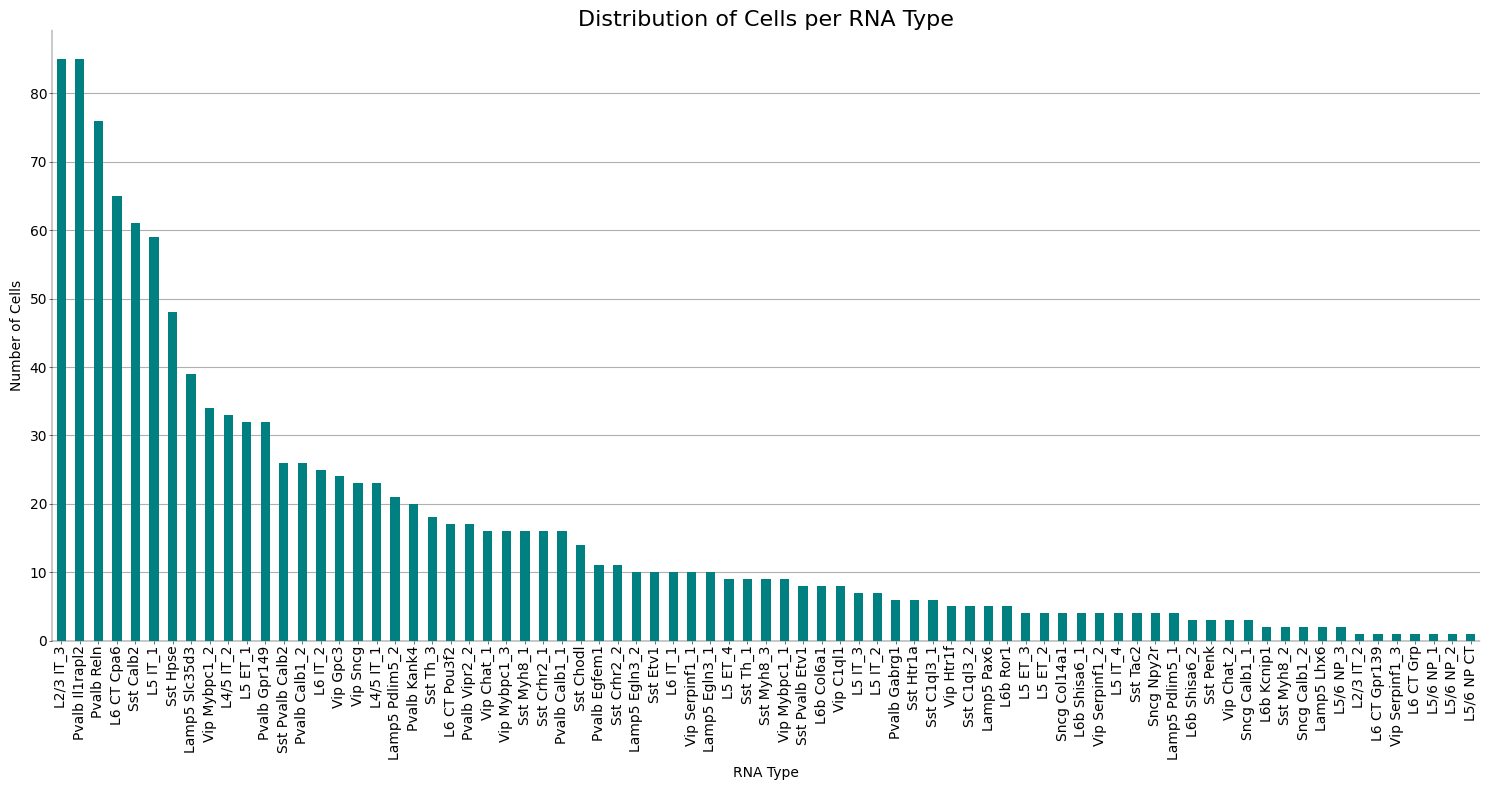

In [28]:
# Get the relevant metadata for the cells that passed initial QC
meta_qc = meta[exclude_low_quality].copy()

# --- Plotting RNA Family Distribution ---
fig, ax = plt.subplots(figsize=(10, 6))
family_counts = meta_qc["RNA family"].value_counts()
family_counts.plot(kind="bar", ax=ax, color="steelblue", zorder=10)
ax.set_title("Distribution of Cells per RNA Family", fontsize=16)
ax.set_xlabel("RNA Family")
ax.set_ylabel("Number of Cells")
ax.grid(axis="y")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# --- Plotting RNA Type Distribution ---
# This will be a busy plot due to 77 types, so we'll focus on the most abundant ones.
fig, ax = plt.subplots(figsize=(15, 8))
type_counts = meta_qc["RNA type"].value_counts()
type_counts.plot(kind="bar", ax=ax, color="teal", zorder=10)
ax.set_title("Distribution of Cells per RNA Type", fontsize=16)
ax.set_xlabel("RNA Type")
ax.set_ylabel("Number of Cells")
ax.grid(axis="y")
plt.tight_layout()
plt.show()

C:\Users\Julius\AppData\Local\Temp\ipykernel_10628\4150894461.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


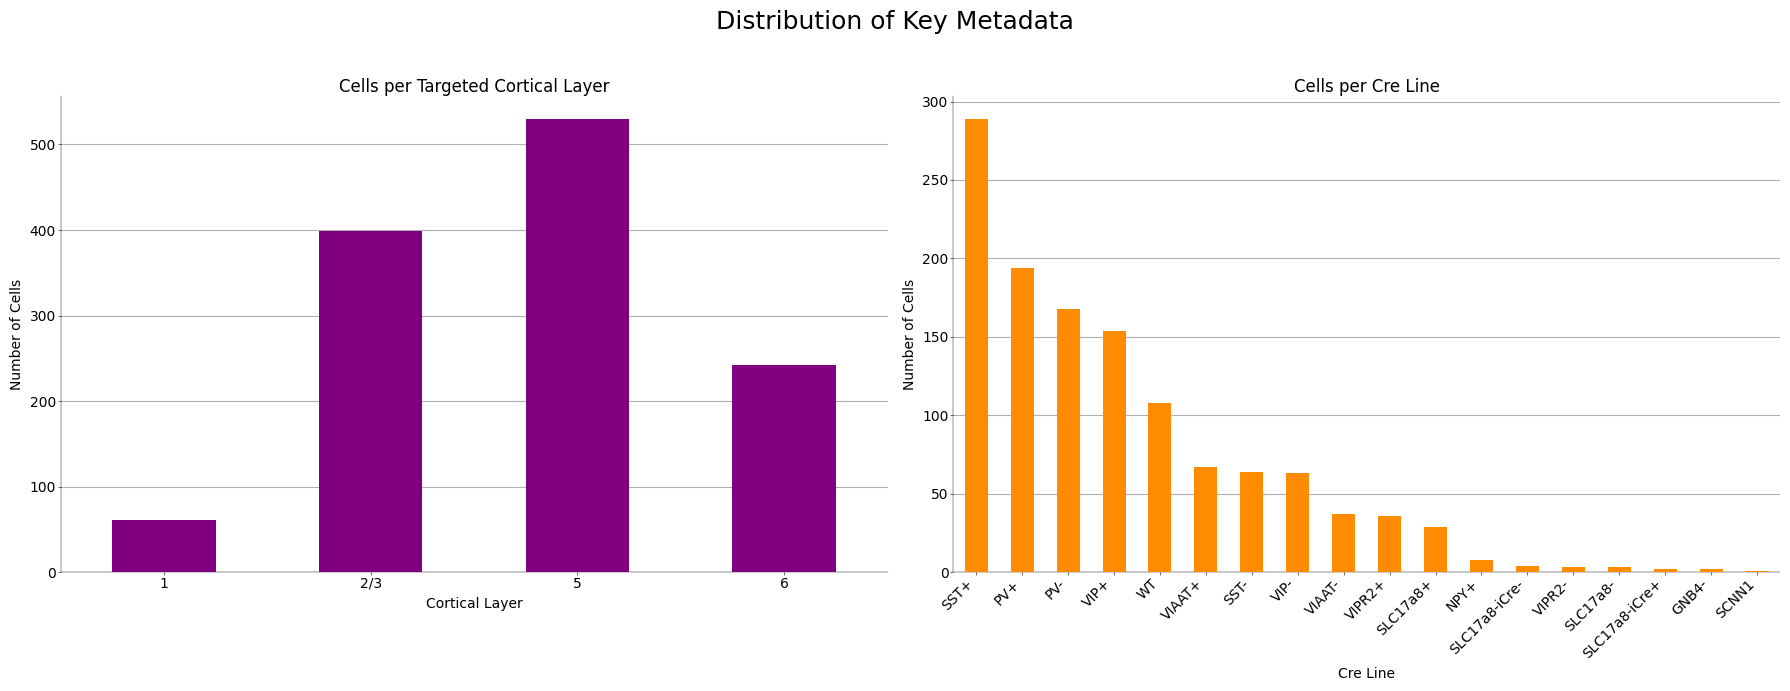

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Distribution of Key Metadata", fontsize=18)

# Plot 1: Targeted Cortical Layer
layer_counts = meta_qc["Targeted layer"].value_counts().sort_index()
layer_counts.plot(kind="bar", ax=axes[0], color="purple", zorder=10)
axes[0].set_title("Cells per Targeted Cortical Layer")
axes[0].set_xlabel("Cortical Layer")
axes[0].set_ylabel("Number of Cells")
axes[0].grid(axis="y")
axes[0].tick_params(axis="x", rotation=0)

# Plot 2: Cre Line
cre_counts = meta_qc["Cre"].value_counts()
cre_counts.plot(kind="bar", ax=axes[1], color="darkorange", zorder=10)
axes[1].set_title("Cells per Cre Line")
axes[1].set_xlabel("Cre Line")
axes[1].set_ylabel("Number of Cells")
axes[1].grid(axis="y")
plt.xticks(rotation=45, ha="right")

plt.tight_layout(rect=[0, 0, 1, 0.96]);
plt.show()